In [1]:
import utils as u

from matplotlib.pyplot import *
import matplotlib as mpl

from scipy.fft import *
import numpy as np

import numba
@numba.vectorize([numba.float64(numba.complex128),numba.float32(numba.complex64)])
def abs2(x):
    return x.real**2 + x.imag**2

# Constants and parameters

In [3]:
# Constants
nu_darkring = 1.22*np.pi    # location of first airy ring minimum for an unobstructed, circular, optic.
N_Rayleigh = 16             # N_{Rayleigh} (i.e. number of nu's to plot)

N_Airy = 256                # N_{Airy} (i.e. number of pixels between peak and first min)
N = N_Rayleigh*N_Airy*2     # size of array and bessel function
N_na = 1.22*(N/2)/N_Airy    # radius of aperture
b = .5                      # fractional diameter of central stop

downscale_factor = 32       # Degree of downscaling to smooth aperture edge

# Domains
airy_1 = np.linspace(-nu_darkring, nu_darkring, N_Airy*2)       # domain of first airy ring for unobstructed aperture
airy_n = np.linspace(-nu_darkring*N_Rayleigh, nu_darkring*N_Rayleigh, N_Airy*N_Rayleigh*2) # domain of nth airy ring

print('Array size =',str(N)+'x'+str(N), '\n',
      '\rAperature radius =',N_na, '\n',
      '\rCentral stop fraction =',b)

Array size = 8192x8192 
Aperature radius = 19.52 
Central stop fraction = 0.5


# Generate arrays and Bessel function result

In [4]:
# Generate open aperture and diffraction pattern
a = u.create_aperture(aperture_radius = N_na, array_size = N, downscale_factor = downscale_factor, b = 0, shift_percent = 0)
a /= np.sum(a)
print('Open aperture FFT...', end = '\r')
A = abs2(fftshift(fft2(a, workers=-1), axes = (0,1)))

# Generate aperture w/ central stop and diffraction pattern
a_cs = u.create_aperture(aperture_radius = N_na, array_size = N, downscale_factor = downscale_factor, b = b, shift_percent = 0)
a_cs /= np.sum(a_cs)
print('Central stop FFT...', end = ' \r')
A_cs = abs2(fftshift(fft2(a_cs, workers=-1), axes = (0,1)))

# Generate diffraction profile with bessel function
bessel = u.psf(airy_n)
bessel_cs = u.psf(airy_n, b)

print('DONE '*10)

DONE DONE DONE DONE DONE DONE DONE DONE DONE DONE 


# Plot

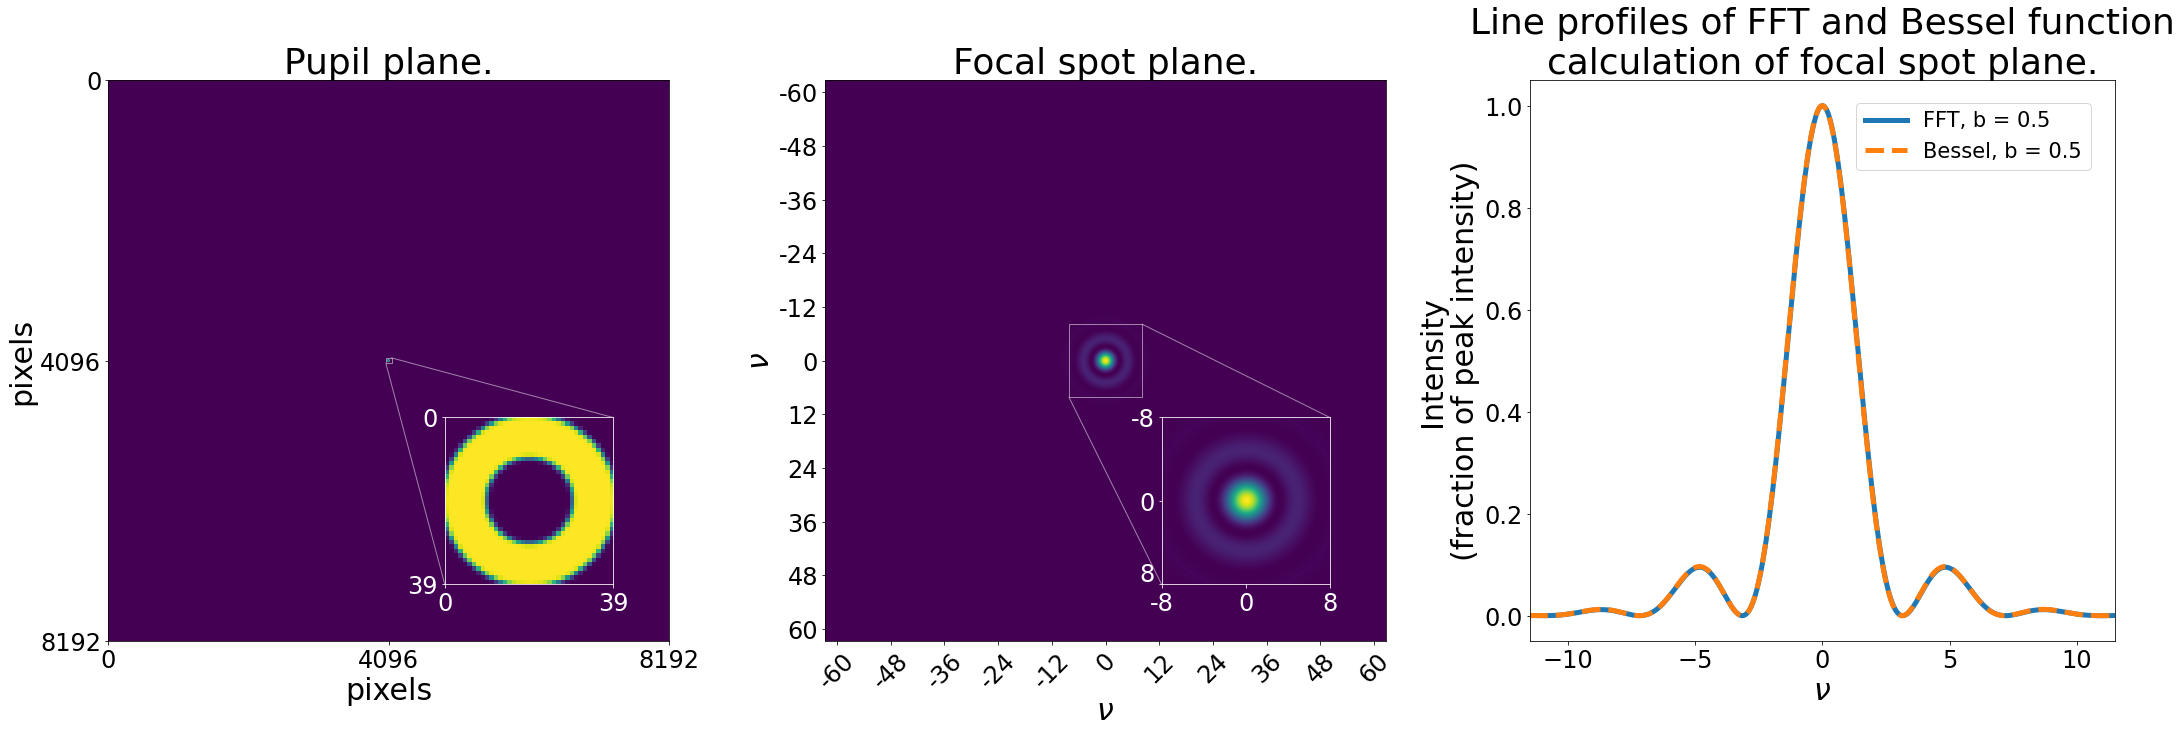

In [5]:
rcParams['svg.fonttype'] = 'none'
mpl.rcParams['lines.linewidth'] = 5
mpl.rcParams['axes.titlesize'] = 36
mpl.rcParams['axes.labelsize'] = 30
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['legend.fontsize'] = 21
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


plot_nu = 8
lim = np.argwhere(np.abs(airy_n) < plot_nu)[[0,-1]].flatten()

fig, axes = subplots(1,3, figsize = (15*2,5*2), facecolor = 'white')
axes[0].imshow(a_cs)

# inset axes....
extent = [a_cs.shape[0]//2-int(N_na+2)-20,a_cs.shape[0]//2+int(N_na+2)+20,
                   a_cs.shape[1]//2-int(N_na+2)-20,a_cs.shape[1]//2+int(N_na+2)+20]
axins0 = axes[0].inset_axes([0.6, 0.1, 0.3, 0.3])
axins0.imshow(a_cs[a_cs.shape[0]//2-int(N_na):a_cs.shape[0]//2+int(N_na),
                   a_cs.shape[1]//2-int(N_na):a_cs.shape[1]//2+int(N_na)], origin="lower",extent=extent)
axins0.set_xticks(extent[0:2])
axins0.set_xticklabels([0,int(N_na*2)], color = 'white')
axins0.set_yticks(extent[0:2])
axins0.set_yticklabels([int(N_na*2),0], color = 'white')
axins0.xaxis.label.set_color('white')
axins0.tick_params(color='white', labelcolor='white')
for spine in axins0.spines.values():
    spine.set_edgecolor('white')
axes[0].indicate_inset_zoom(axins0, edgecolor="white")
axes[0].set_title('Pupil plane.')
axes[0].set_xlabel('pixels')
axes[0].set_ylabel('pixels')
axes[0].set_xticks([0,a_cs.shape[0]//2,a_cs.shape[0]])
axes[0].set_yticks([0,a_cs.shape[0]//2,a_cs.shape[0]])


axes[1].imshow(A_cs)
axes[1].set_title('Focal spot plane.')
extent = [lim[0],lim[1],lim[0],lim[1]]
axins1 = axes[1].inset_axes([0.6, 0.1, 0.3, 0.3])
axins1.imshow(A_cs[lim[0]:lim[1],lim[0]:lim[1]], origin="lower",extent=extent)
axins1.set_xticks([extent[0], (extent[0]+extent[1])/2, extent[1]])
axins1.set_xticklabels([-plot_nu,0,plot_nu], color = 'white')
axins1.set_yticks([extent[0], (extent[0]+extent[1])/2, extent[1]])
axins1.set_yticklabels([str(plot_nu)+'\n',0,str(-plot_nu)], color = 'white')
axins1.xaxis.label.set_color('white')
axins1.tick_params(color='white', labelcolor='white')
for spine in axins1.spines.values():
    spine.set_edgecolor('white')
axes[1].indicate_inset_zoom(axins1, edgecolor="white")
axes[1].set_xticks(np.linspace(A_cs.shape[0]-A_cs.shape[0]*60/(16*nu_darkring),A_cs.shape[0]*60/(16*nu_darkring),11))
axes[1].set_xticklabels((-np.arange(6)*4*3).tolist()[::-1]+(np.arange(6)*4*3).tolist()[1::], rotation=45)
axes[1].set_yticks(np.linspace(A_cs.shape[0]-A_cs.shape[0]*60/(16*nu_darkring),A_cs.shape[1]*60/(16*nu_darkring),11))
axes[1].set_yticklabels((-np.arange(6)*4*3).tolist()[::-1]+(np.arange(6)*4*3).tolist()[1::])
axes[1].set_xlabel(r'$\nu$')
axes[1].set_ylabel(r'$\nu$')

axes[2].plot(airy_n, A_cs[A_cs.shape[0]//2,:], label = 'FFT, b = 0.5')
axes[2].plot(airy_n, bessel_cs, linestyle = '--', label = 'Bessel, b = 0.5')
axes[2].set_ylabel('Intensity\n(fraction of peak intensity)')
axes[2].set_xlabel(r'$\nu$')
axes[2].set_xlim(-3*nu_darkring, 3*nu_darkring)
axes[2].set_title('Line profiles of FFT and Bessel function\ncalculation of focal spot plane.')

axes[2].legend(loc='center left', bbox_to_anchor=(.54, 0.9))
tight_layout()
show()